# 3.2 Задача о штате IT-компании

In [54]:
import sqlite3
import pandas as pd
import numpy as np
from collections import defaultdict
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [55]:

cnx = sqlite3.connect('employee.db')

df = pd.read_sql_query("SELECT * from employees;", cnx)


In [56]:
df.head()

,id,name,boss_id
0,1,Rebecca Slaughter,NaN
1,2,Brian Hudson,NaN
2,3,Charles Fillmore,NaN
3,4,Toby Spaulding,NaN
4,5,Orlando Mays,NaN


In [57]:
def parse_events(filename):
    with open(filename,'r') as f:
        lines = f.read().splitlines()
    result = []
    temp= []
    for i in range(1,len(lines)):
        line = lines[i] 
        if line == '---':
            result.append(temp)
            temp = []
            continue
        elif line == '':
            continue
        elif line.startswith('Name:'):
            line = line[len('Name:'):].strip()
        elif line.startswith('Date:'):
            line = line[len('Date:'):].strip()
        elif line.startswith('Boss:'):
            line = line[len('Boss:'):].strip()
            
            
        temp.append(line)
    result.append(temp)
    return result

In [58]:
events = pd.DataFrame(parse_events('events.txt'))
events.columns = ['name','date','event','boss']
events['dateStr'] = events['date']
events['date'] = pd.to_datetime(events['date'])

In [59]:
events['event'].unique()

array(['Transfer', 'Hire', 'Fire'], dtype=object)

In [60]:
for event in ['Fire','Hire','Transfer']:
    print(events[events['event']==event].head(1))

             name       date event  boss     dateStr
4  Karen Spannaus 2018-01-03  Fire  None  2018-01-03
            name       date event           boss     dateStr
2  Orpha Gilmore 2018-01-01  Hire  Bradley Dirks  2018-01-01
              name       date     event             boss     dateStr
0  Carolyn Johnson 2018-01-01  Transfer  Geoffrey Larsen  2018-01-01


Смотрим пропуски

In [61]:
df.isna().sum()

id          0
name        0
boss_id    10
dtype: int64

10 пропусков в boss_id - записи руководителей

In [62]:
set(events.name.unique())-set(df.name.unique())

set()

In [63]:
set(df.name.unique()) - set(events.name.unique())

{'Brian Hudson',
 'Charles Fillmore',
 'David Lee',
 'Donna Cranker',
 'Geoffrey Larsen',
 'Michael Teixeira',
 'Orlando Mays',
 'Oscar Tharp',
 'Rebecca Slaughter',
 'Toby Spaulding'}

Проверяем, что множество name из df содержат все варианты name из таблицы events

## Строим и анализируем граф

In [64]:
def build_graph():
    g = nx.Graph()
    for i,row in df.iterrows():
        id_ = row['id']
        boss_id = row['boss_id']
        if pd.isna(boss_id):
            continue
        g.add_edge(id_, boss_id)
    return g


In [65]:
G = build_graph()

In [66]:
len(list(nx.connected_components(G)))

13

Графов больше чем руководителей отделов, посмотрим на графы без руководителей 

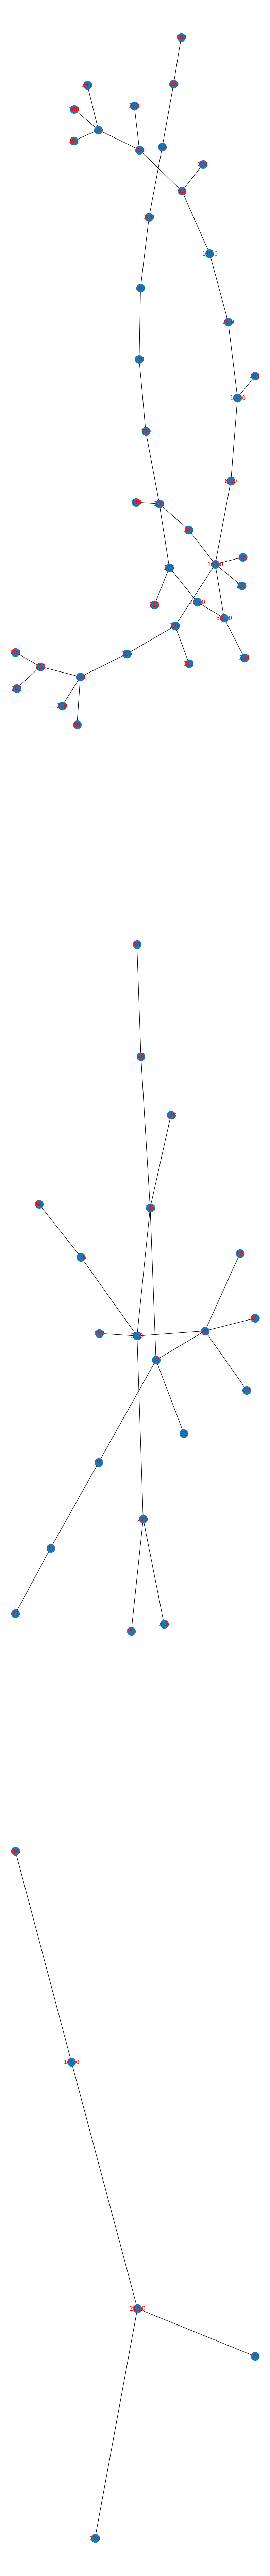

In [67]:
boss_ids = set(i for i in range(1,11))
to_draw = []
for c in components:
    if c & boss_ids:
        continue
    to_draw.append(c)

    
fig, axes = plt.subplots(len(to_draw),1,figsize=(10,100), dpi=100)
components = list(nx.connected_components(G))    

for i in range(len(to_draw)):
    ax = axes[i]
    tempg = G.subgraph(to_draw[i])
    nx.draw(tempg,ax=ax,with_labels = True,font_color='red')


In [68]:
df[df.id.isin([215,220,146,160,79])]

,id,name,boss_id
78,79,Ralph Sikes,215.0
145,146,Rudy Harris,146.0
159,160,Patricia Moore,146.0
214,215,Robert Green,146.0
219,220,Charles Baldwin,215.0


In [69]:
df[df.id==df.boss_id]

,id,name,boss_id
145,146,Rudy Harris,146.0


Похоже, что сотрудник сам себе босс и ему стоило занулить boss_id, больше таких сотрудников нет. Посмотрим на остальные графы. 

In [70]:
df[df.id.isin([39,51,110,97])]

,id,name,boss_id
38,39,Mae Deardorff,51.0
50,51,Colleen Soto,110.0
96,97,Charles Brooks,39.0
109,110,Daniel Hagadone,97.0


Видим цикл в графе, не понятно кто кем руководит.

In [71]:
df[df.id.isin([301,279,255,203,345,161])]

,id,name,boss_id
160,161,Gregory Ruybal,301.0
202,203,Alicia Viviano,345.0
254,255,Mary Williams,203.0
278,279,Sheena Counter,255.0
300,301,Joann Weaver,279.0
344,345,David Drage,161.0


Видим цикл в графе, не понятно кто кем руководит.

## Построим график

In [72]:
components = list(nx.connected_components(G)) 

name_id_map = {row['name']:row['id'] for i,row in df.iterrows()}
emp_id_boss_id_map = {row['id']: row['boss_id'] for i,row in df.iterrows()}


flags = {}
department_emp_num = defaultdict(int)

for i,dep in enumerate(components):
    for item in dep:
        flags[item] = i
    department_emp_num[i] = len(dep)
        

In [73]:
from copy import copy

def hire(p,c):
    flag = flags[p]
    flags[c] =  flag
    department_emp_num[flag]+=1
    name_id_map[name] = emp_id
    emp_id_boss_id_map[emp_id] = boss_id
    
def fire(p,c):
    flag = flags[c]
    del flags[c]
    department_emp_num[flag]-=1
    
def transfer(oldp,newp,c):
    old_flag = flags[c]
    new_flag = flags[newp]
    if old_flag != new_flag:
        flags[c] = new_flag
        department_emp_num[old_flag]-=1
        department_emp_num[new_flag]+=1

result = {}
id_count = df.shape[0]
for i,item in events.sort_values(by='date').iterrows():
    event = item['event']
    name  = item['name']
    boss = item['boss']
    if event == 'Hire':
        id_count+=1
        emp_id = id_count
        boss_id = name_id_map[boss]
        hire(boss_id,emp_id)
    elif event == 'Fire':
        emp_id = name_id_map[name]
        boss_id = emp_id_boss_id_map[emp_id]
        fire(boss_id,emp_id)
    elif event == 'Transfer':
        emp_id = name_id_map[name]
        new_boss_id = name_id_map[boss]
        old_boss_id = emp_id_boss_id_map[emp_id]
        transfer(old_boss_id,new_boss_id,emp_id)
        emp_id_boss_id_map[emp_id]=new_boss_id
    result[item['date']] = copy(department_emp_num)

In [74]:
result = pd.DataFrame(result.values(),index=result.keys()).reset_index()

In [75]:
result['week'] = result['index'].dt.to_period('W-MON')


In [76]:
cleared_result = result.groupby('week').first().drop(columns=['index'])

## Итоговый график

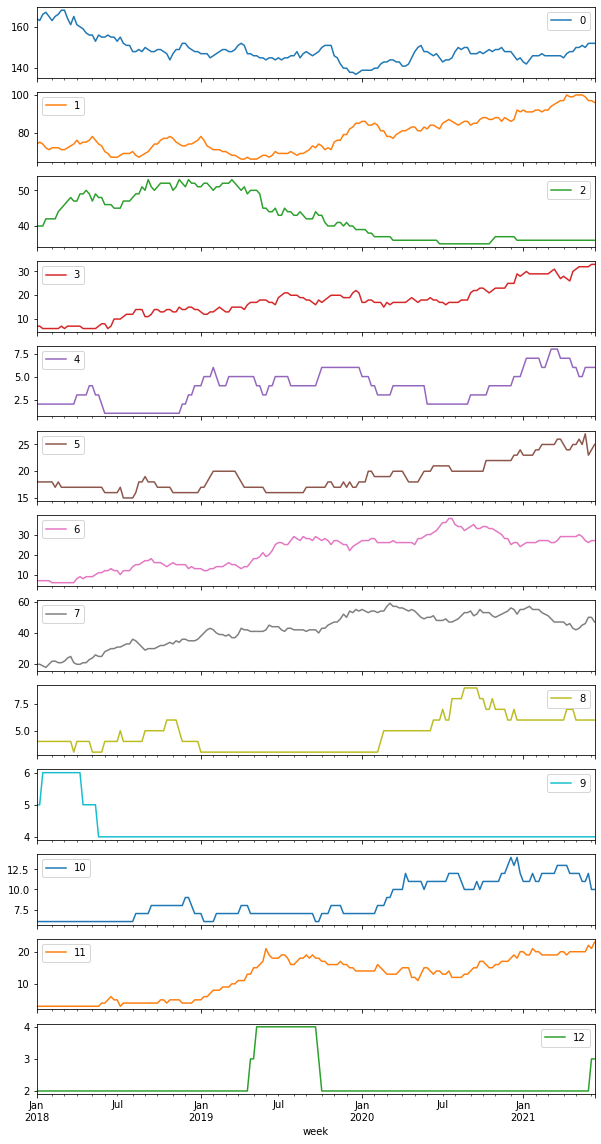

In [77]:
_ = cleared_result.plot(subplots=True,figsize=(10,20))